In [ ]:
# 1. Install Dependencies and Setup

!pip install tensorflow opencv-python matplotlib



In [ ]:
!pip list

In [1]:
import tensorflow as tf
import os

In [2]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [3]:
tf.config.list_physical_devices('GPU')

[]

# 2. Remove dodgy images

In [4]:
import cv2
import imghdr

C:\Users\avira\AppData\Local\Temp\ipykernel_19512\4232469594.py:2: DeprecationWarning: 'imghdr' is deprecated and slated for removal in Python 3.13
  import imghdr


In [5]:
data_dir = 'data' 

In [6]:
image_exts = ['jpeg','jpg', 'bmp', 'png']

In [7]:
for image_class in os.listdir(data_dir): 
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try: 
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts: 
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e: 
            print('Issue with image {}'.format(image_path))
            # os.remove(image_path)

# 3. Load Data

In [8]:
import numpy as np
from matplotlib import pyplot as plt

In [9]:
data = tf.keras.utils.image_dataset_from_directory('data')

Found 857 files belonging to 2 classes.


In [10]:
data_iterator = data.as_numpy_iterator()

In [11]:
#Class 1 = Rotten
#Class 0 = Fresh
batch = data_iterator.next()

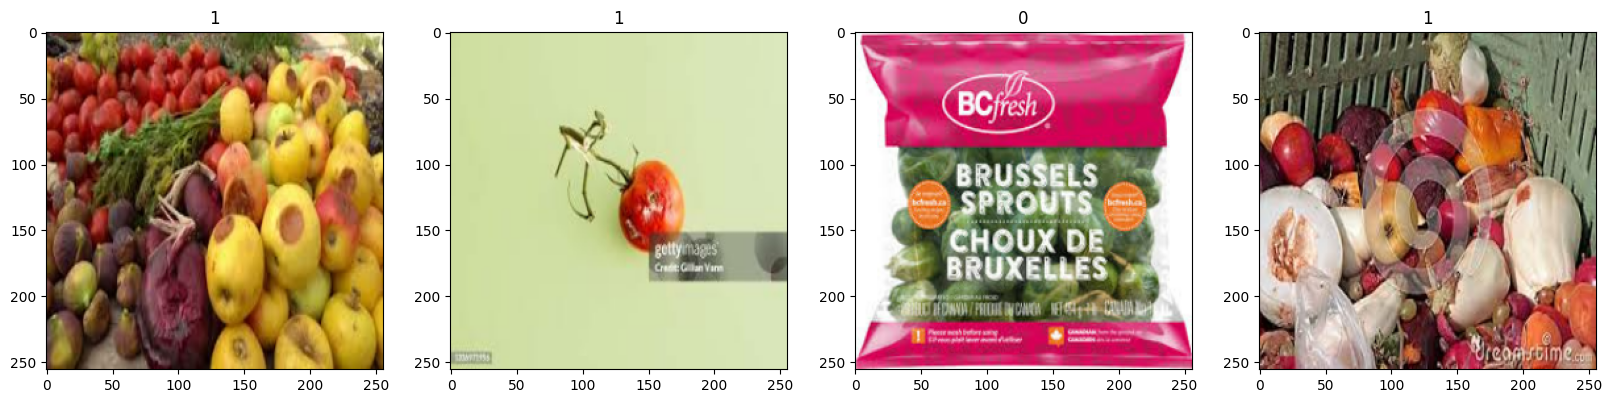

In [12]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

# 4. Scale Data

In [13]:
data = data.map(lambda x,y: (x/255, y))

In [14]:
data.as_numpy_iterator().next()

(array([[[[0.4316636 , 0.5453891 , 0.7179381 ],
          [0.44096202, 0.5542509 , 0.72810966],
          [0.45854014, 0.56834406, 0.7526578 ],
          ...,
          [0.9458257 , 0.9087929 , 0.6264399 ],
          [0.94509804, 0.90588236, 0.62352943],
          [0.94509804, 0.90588236, 0.62352943]],
 
         [[0.4113827 , 0.5207864 , 0.691008  ],
          [0.4190199 , 0.53205895, 0.70142937],
          [0.44058672, 0.5489793 , 0.72838825],
          ...,
          [0.9458257 , 0.9124484 , 0.6300955 ],
          [0.9470924 , 0.90837634, 0.6260234 ],
          [0.9473422 , 0.90812653, 0.6257736 ]],
 
         [[0.37933517, 0.4832985 , 0.6495286 ],
          [0.38598138, 0.49745712, 0.66134626],
          [0.41253063, 0.5166994 , 0.6913164 ],
          ...,
          [0.94695157, 0.9163067 , 0.63395375],
          [0.9487084 , 0.912367  , 0.63001406],
          [0.9490196 , 0.91205573, 0.6297028 ]],
 
         ...,
 
         [[0.41659772, 0.3316636 , 0.16989192],
          [0.37444

In [15]:
# 5. Split Data

In [16]:
len(data)

27

In [17]:
27 * .7

18.9

In [18]:
27 * .2

5.4

In [19]:
27 * .1

2.7

In [20]:
train_size = int(len(data)*.7)+1
val_size = int(len(data)*.2)
test_size = int(len(data)*.1)+1

In [21]:
train_size

19

In [22]:
val_size

5

In [23]:
test_size

3

In [24]:
train_size + val_size + test_size

27

In [25]:
train = data.take(train_size) 
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

# 6. Build Deep Learning Model

In [26]:
train

<_TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [27]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [28]:
model = Sequential()

In [29]:
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())
model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

P:\ImageClassification\freshness\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [30]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [31]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 254, 254, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 127, 127, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 125, 125, 32)        │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 62, 62, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 60, 60, 16)          │           4,624 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 30, 30, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 14400)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │       3,686,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,696,625 (14.10 MB)

 Trainable params: 3,696,625 (14.10 MB)

 Non-trainable params: 0 (0.00 B)

# 7. Train

In [32]:
logdir='logs'

In [33]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [34]:
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 15s 472ms/step - accuracy: 0.5251 - loss: 1.3721 - val_accuracy: 0.6687 - val_loss: 0.6159
Epoch 2/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 9s 464ms/step - accuracy: 0.7533 - loss: 0.5462 - val_accuracy: 0.7812 - val_loss: 0.5311
Epoch 3/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 15s 753ms/step - accuracy: 0.7831 - loss: 0.4608 - val_accuracy: 0.7437 - val_loss: 0.5350
Epoch 4/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 10s 516ms/step - accuracy: 0.7965 - loss: 0.4586 - val_accuracy: 0.8062 - val_loss: 0.3914
Epoch 5/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 12s 581ms/step - accuracy: 0.8271 - loss: 0.3953 - val_accuracy: 0.8313 - val_loss: 0.3802
Epoch 6/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 17s 924ms/step - accuracy: 0.8905 - loss: 0.3037 - val_accuracy: 0.8125 - val_loss: 0.3618
Epoch 7/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 12s 577ms/step - accuracy: 0.8744 - loss: 0.2759 - val_accuracy: 0.9125 - val_loss: 0.2460
Epoch 8/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 12s 537ms/step - accuracy: 0.9303 - loss: 0.2053 - val_accur

# 8. Plot Performance

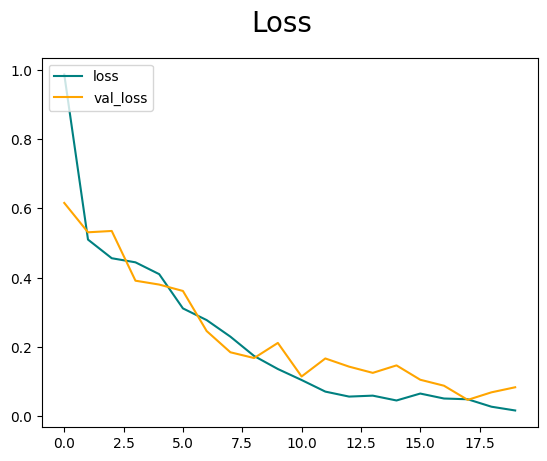

In [35]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

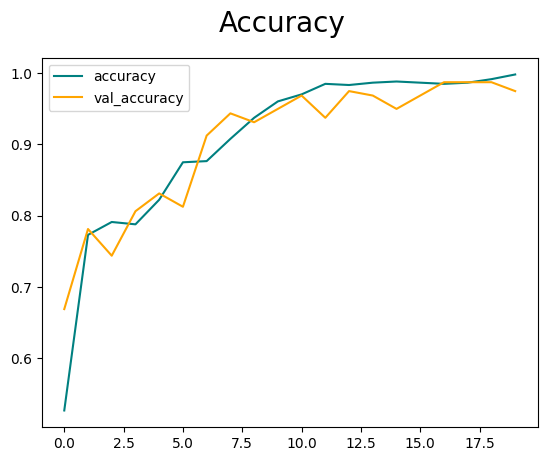

In [36]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

# 9. Evaluate

In [37]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [38]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [39]:
for batch in test.as_numpy_iterator(): 
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step


In [40]:
print(f'Precision:{pre.result().numpy()}, Recall:{re.result().numpy()}, Accuracy:{acc.result().numpy()}')

Precision:0.9599999785423279, Recall:1.0, Accuracy:0.9775280952453613


# 10. Test

In [41]:
import cv2

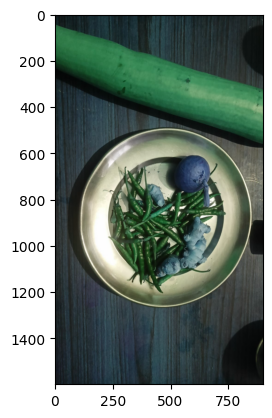

In [42]:
img = cv2.imread('freshtest.jpg')
plt.imshow(img)
plt.show()

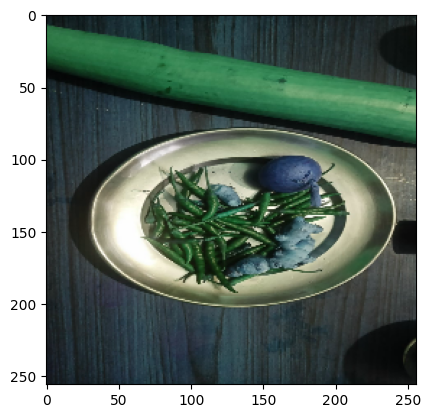

In [43]:
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [44]:
yhat = model.predict(np.expand_dims(resize/255, 0))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


In [45]:
yhat

array([[4.4940444e-07]], dtype=float32)

In [46]:
if yhat > 0.5: 
    print(f'Predicted class is Rotten')
else:
    print(f'Predicted class is Fresh')

Predicted class is Fresh


# 11. Save the Model

In [54]:
from tensorflow.keras.models import load_model

In [58]:
model.save('FreshnessIndex.keras')

In [59]:
new_model = load_model('FreshnessIndex.keras')

P:\ImageClassification\freshness\Lib\site-packages\keras\src\saving\saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 12 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [60]:
new_model.predict(np.expand_dims(resize/255, 0))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


array([[4.4940444e-07]], dtype=float32)